#Maybe overkill...

In [79]:
import random as rd
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt

#submit = True
submit = False

In [80]:
# load the public MNIST dataset.
(x_train, y_train),(x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000,784)
x_test = x_test.reshape(10000,784)

x_train_norm = x_train/255.
x_test_norm = x_test/255.
x_test_norm = x_test.reshape((10000, 28, 28, 1))

In [81]:
k_train = pd.read_csv('../input/digit-recognizer/train.csv')
k_labels = np.asarray(k_train['label'])
k_train = k_train.drop(columns=['label'])
k_train_norm = np.asarray(k_train/255.)

#val_set_labels = k_labels[-2000:]
#val_set_norm = k_train_norm[-2000:]
#val_set_norm = val_set_norm.reshape(2000, 28, 28, 1)

#k_train_norm = k_train_norm[:-2000]
#k_labels = k_labels[:-2000]

In [82]:
#x_data = [row for row in x_test_norm]
x_data = [row for row in x_train_norm]
x_data += [row for row in k_train_norm]
x_data = np.asarray(x_data)
x_data = x_data.reshape((102000, 28, 28, 1))

#y_data = [label for label in y_test]
y_data = [label for label in y_train]
y_data += [label for label in k_labels]
y_data = np.asarray(y_data).flatten()

In [83]:
# train on the training set with some held back for validation #
def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=None, verbose=0):

    history = model.fit(x=train_features, y=train_label, 
                        batch_size=batch_size,
                        epochs=epochs, shuffle=True, 
                        validation_split=validation_split,
                        verbose = verbose)

    # Gather the model's metrics after each round of training
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    return epochs, hist

In [84]:
 # Set up a CNN with Keras
 
def create_CNN(learning_rate):
    """Create and compile a convolutional neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 6, activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, 4, activation='relu'))
    model.add(tf.keras.layers.Conv2D(128, 2, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model

In [85]:
def create_DNN(learning_rate):
    """Create and compile a deep neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Dense(units=1024, activation='relu'))  
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model

In [86]:
def create_mixedNN(learning_rate):
    """Create and compile a deep neural net."""  
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(32, 6, activation='relu', input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Conv2D(64, 3, activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((2,2)))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model

In [105]:
def getUbermodel(learning_rate):#, modelA, modelB, modelC, modelD):
    """UberNN of four digit-recognizing neural nets."""  
    # Get predictions from pre-trained drNNs
    #predA = modelA.predict
    
    # Define the kind of model to use.
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten( input_shape=(30,1) ))
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))  
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(units=512, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(units=10, activation='softmax'))     
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                    loss="sparse_categorical_crossentropy",
                    metrics=['accuracy']) 
    return model

In [93]:
# Train and evalate CNN on ALL the datasets, 
# Train on 10000 + 60000 + 42000 to predict on 28000
learning_rate = 0.001
epochs = 40
batch_size = 500

if submit:
    validation_split = None
    verbose = 0
else:
    validation_split = 0.005 # 0.5% off bottom of each array
    verbose = 1
start_time = time.time()

model_A = create_CNN(learning_rate)
model_B = create_DNN(learning_rate)
model_C = create_mixedNN(learning_rate)

#x_test_norm:
epochs_A, hist_A = train_model(model_A, x_data, y_data, epochs, batch_size, validation_split, verbose=verbose)
if not submit:
    print("\nTrained model A in about {} seconds\n".format((round(time.time()-start_time,4))))
batch_time = time.time()

#x_train_norm:
epochs_B, hist_B = train_model(model_B, x_data, y_data, epochs, batch_size, validation_split, verbose=verbose)
if not submit:
    print("\nTrained model B in about {} seconds\n".format((round(time.time()-start_time,4))))
batch_time = time.time()

#k_train_norm:
epochs_C, hist_C = train_model(model_C, x_data, y_data, epochs, batch_size, validation_split, verbose=verbose)
if not submit:
    print("\nTrained model C in about {} seconds\n".format((round(time.time()-start_time,4))))

if not submit:
    print ("\nTotal time: {} seconds is about {} minutes.".format(round(time.time()-start_time,4),
                                                              (time.time()-start_time)//60))

Epoch 1/40
203/203 [==============================] - 4s 18ms/step - loss: 0.2228 - accuracy: 0.9371 - val_loss: 0.0465 - val_accuracy: 0.9824
Epoch 2/40
203/203 [==============================] - 4s 18ms/step - loss: 0.0518 - accuracy: 0.9842 - val_loss: 0.0294 - val_accuracy: 0.9902
Epoch 3/40
203/203 [==============================] - 4s 18ms/step - loss: 0.0360 - accuracy: 0.9889 - val_loss: 0.0188 - val_accuracy: 0.9941
Epoch 4/40
203/203 [==============================] - 4s 18ms/step - loss: 0.0281 - accuracy: 0.9912 - val_loss: 0.0193 - val_accuracy: 0.9941
Epoch 5/40
203/203 [==============================] - 4s 18ms/step - loss: 0.0223 - accuracy: 0.9932 - val_loss: 0.0158 - val_accuracy: 0.9961
Epoch 6/40
203/203 [==============================] - 4s 17ms/step - loss: 0.0163 - accuracy: 0.9950 - val_loss: 0.0202 - val_accuracy: 0.9922
Epoch 7/40
203/203 [==============================] - 4s 18ms/step - loss: 0.0141 - accuracy: 0.9955 - val_loss: 0.0135 - val_accuracy: 0.9961

203/203 [==============================] - 1s 4ms/step - loss: 0.0149 - accuracy: 0.9950 - val_loss: 0.0066 - val_accuracy: 0.9980
Epoch 18/40
203/203 [==============================] - 1s 3ms/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.0098 - val_accuracy: 0.9961
Epoch 19/40
203/203 [==============================] - 1s 3ms/step - loss: 0.0132 - accuracy: 0.9955 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 20/40
203/203 [==============================] - 1s 3ms/step - loss: 0.0142 - accuracy: 0.9955 - val_loss: 0.0139 - val_accuracy: 0.9980
Epoch 21/40
203/203 [==============================] - 1s 4ms/step - loss: 0.0131 - accuracy: 0.9960 - val_loss: 0.0039 - val_accuracy: 0.9980
Epoch 22/40
203/203 [==============================] - 1s 4ms/step - loss: 0.0135 - accuracy: 0.9955 - val_loss: 0.0047 - val_accuracy: 0.9980
Epoch 23/40
203/203 [==============================] - 1s 4ms/step - loss: 0.0116 - accuracy: 0.9963 - val_loss: 0.0149 - val_accuracy: 0.9961
Epoch 24/40

203/203 [==============================] - 2s 11ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 1.8415e-05 - val_accuracy: 1.0000
Epoch 34/40
203/203 [==============================] - 2s 12ms/step - loss: 0.0018 - accuracy: 0.9995 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 35/40
203/203 [==============================] - 2s 11ms/step - loss: 8.9630e-04 - accuracy: 0.9997 - val_loss: 1.6347e-04 - val_accuracy: 1.0000
Epoch 36/40
203/203 [==============================] - 2s 11ms/step - loss: 0.0042 - accuracy: 0.9989 - val_loss: 9.8345e-04 - val_accuracy: 1.0000
Epoch 37/40
203/203 [==============================] - 3s 12ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9980
Epoch 38/40
203/203 [==============================] - 2s 12ms/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 2.2646e-05 - val_accuracy: 1.0000
Epoch 39/40
203/203 [==============================] - 3s 13ms/step - loss: 9.9268e-04 - accuracy: 0.9997 - val_loss: 1.2006e-05

In [106]:
model_A.save('model_A1')
model_B.save('model_B1')
model_C.save('model_C1')

In [94]:
if not submit:
    print ("Evaluate against x_test_norm:")
    print ("A:",model_A.evaluate(x_test_norm, y_test, batch_size=100))
    print ("B:",model_B.evaluate(x_test_norm, y_test, batch_size=100))
    print ("C:",model_C.evaluate(x_test_norm, y_test, batch_size=100))

Evaluate against x_test_norm:
100/100 [==============================] - 0s 3ms/step - loss: 4.4141 - accuracy: 0.9974
A: [4.414113521575928, 0.9973999857902527]
100/100 [==============================] - 0s 2ms/step - loss: 7.3539 - accuracy: 0.9936
B: [7.353908538818359, 0.9936000108718872]
100/100 [==============================] - 0s 2ms/step - loss: 4.0566 - accuracy: 0.9963
C: [4.056558132171631, 0.9962999820709229]


In [107]:
uberdataA = getProbabilities(model_A, x_test_norm)
uberdataB = getProbabilities(model_B, x_test_norm)
uberdataC = getProbabilities(model_C, x_test_norm)
uberdata = np.zeros((10000,30))
uberdata[:,:10] = uberdataA
uberdata[:,10:20] = uberdataB
uberdata[:,20:30] = uberdataC

uberdata = uberdata.reshape(-1,30,1)

In [103]:
getUbermodel(learning_rate)

In [108]:
#Ubermodel train:
ubermodel = getUbermodel(learning_rate)
epochs_U, hist_U = train_model(ubermodel, uberdata, y_test, epochs, batch_size, validation_split, verbose=verbose)

if not submit:
    print("\nTrained model C in about {} seconds\n".format((round(time.time()-start_time,4))))


Epoch 1/40
20/20 [==============================] - 0s 9ms/step - loss: 0.8574 - accuracy: 0.9331 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 2/40
20/20 [==============================] - 0s 3ms/step - loss: 0.0149 - accuracy: 0.9978 - val_loss: 1.9118e-05 - val_accuracy: 1.0000
Epoch 3/40
20/20 [==============================] - 0s 3ms/step - loss: 0.0131 - accuracy: 0.9979 - val_loss: 5.4572e-05 - val_accuracy: 1.0000
Epoch 4/40
20/20 [==============================] - 0s 6ms/step - loss: 0.0131 - accuracy: 0.9975 - val_loss: 5.0477e-05 - val_accuracy: 1.0000
Epoch 5/40
20/20 [==============================] - 0s 7ms/step - loss: 0.0112 - accuracy: 0.9984 - val_loss: 1.3133e-04 - val_accuracy: 1.0000
Epoch 6/40
20/20 [==============================] - 0s 5ms/step - loss: 0.0103 - accuracy: 0.9984 - val_loss: 7.4803e-05 - val_accuracy: 1.0000
Epoch 7/40
20/20 [==============================] - 0s 4ms/step - loss: 0.0095 - accuracy: 0.9983 - val_loss: 1.3281e-04 - val_accuracy: 1.0

In [11]:
def getPredictions(model=None, dataset=None): 
    ''' Takes a trained model and data
        Returns a List of guesses for that model on that data
    ''' 
    predictions = []
    predicts = model.predict(dataset)
    for j in range(len(dataset)):
        probs = predicts[j] # one row of 10 probabilities 
        max_id = np.argmax(probs)   # index of top probability in row
        predictions += [max_id]
    return predictions

In [109]:
def getProbabilities(model=None, dataset=None):
    ''' Takes a trained model and a set of data
        Returns a List of guesses by that model for that data
    ''' 
    return model.predict(dataset)

In [12]:
kaggle = pd.read_csv('../input/digit-recognizer/test.csv')
kaggle_norm = np.asarray(kaggle/255.)
kaggle_norm = kaggle_norm.reshape(28000, 28, 28, 1)

In [110]:
kag_guesses = pd.DataFrame(columns=['A', 'B', 'C', 'AB','AC','CB'])

kag_guesses['A'] = getPredictions(model=model3D_A, dataset=kaggle_norm)
kag_guesses['B'] = getPredictions(model=model3D_B, dataset=kaggle_norm)
kag_guesses['C'] = getPredictions(model=model3D_C, dataset=kaggle_norm)

for i in range(len(kag_guesses['A'])):
    kag_guesses['AB'] = kag_guesses['A'] - kag_guesses['B']
    kag_guesses['AC'] = kag_guesses['A'] - kag_guesses['C']
    kag_guesses['CB'] = kag_guesses['C'] - kag_guesses['B']

In [ ]:
kag_probs = pd.DataFrame(columns=list(range(30)))

getProbabilities()
uberguesses = getPredictions(model=ubermodel, )

In [21]:
if not submit:
#All agree on them all!?
    kag_guesses['CB'].sum() + kag_guesses['AC'].sum() + kag_guesses['AB'].sum()
    kag_guesses.to_csv('guessesABC.csv')

In [17]:
if submit:
    kaggles = pd.DataFrame(columns=['ImageId','Label']) 
    kaggles['Label'] = kag_guesses['C']
    kaggles['ImageId'] = [i+1 for i in kaggles.index.values] 
    kaggles.to_csv('submission.csv', columns=["ImageId","Label"], index=False)

##Visualizations

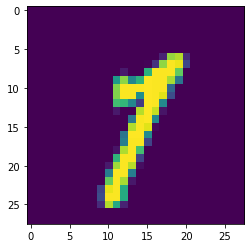

In [61]:
k_img = np.asarray(kaggle.iloc[20044 - 1])
k_img = k_img.reshape(28,28)
plt.imshow(k_img)

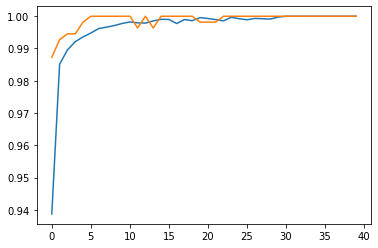

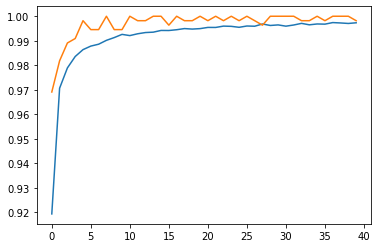

In [18]:
if not submit:
# Plot a graph of the 'accuracy' metric vs. epochs:
    plt.plot(epochs_A,hist_A["accuracy"])
    plt.plot(epochs_A,hist_A["val_accuracy"])
    plt.show()

    plt.plot(epochs_B,hist_B["accuracy"])
    plt.plot(epochs_B,hist_B["val_accuracy"])
    plt.show()